In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Engine Ready: {device} (RTX 5060)")

Engine Ready: cuda (RTX 5060)


In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

print('Finished Training')

Epoch 1, Loss: 1.2287579668909692
Epoch 2, Loss: 0.9136562149238099
Epoch 3, Loss: 0.8035088662448746
Epoch 4, Loss: 0.7278688442524132
Epoch 5, Loss: 0.6758171566154646
Epoch 6, Loss: 0.6345257555584773
Epoch 7, Loss: 0.5957851961941061
Epoch 8, Loss: 0.5645164699886766
Epoch 9, Loss: 0.5307126076668119
Epoch 10, Loss: 0.5074504730494126
Finished Training


In [9]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 83.3 %
Accuracy for class: car   is 88.6 %
Accuracy for class: bird  is 65.5 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 83.5 %
Accuracy for class: dog   is 77.8 %
Accuracy for class: frog  is 82.2 %
Accuracy for class: horse is 89.6 %
Accuracy for class: ship  is 88.0 %
Accuracy for class: truck is 92.0 %


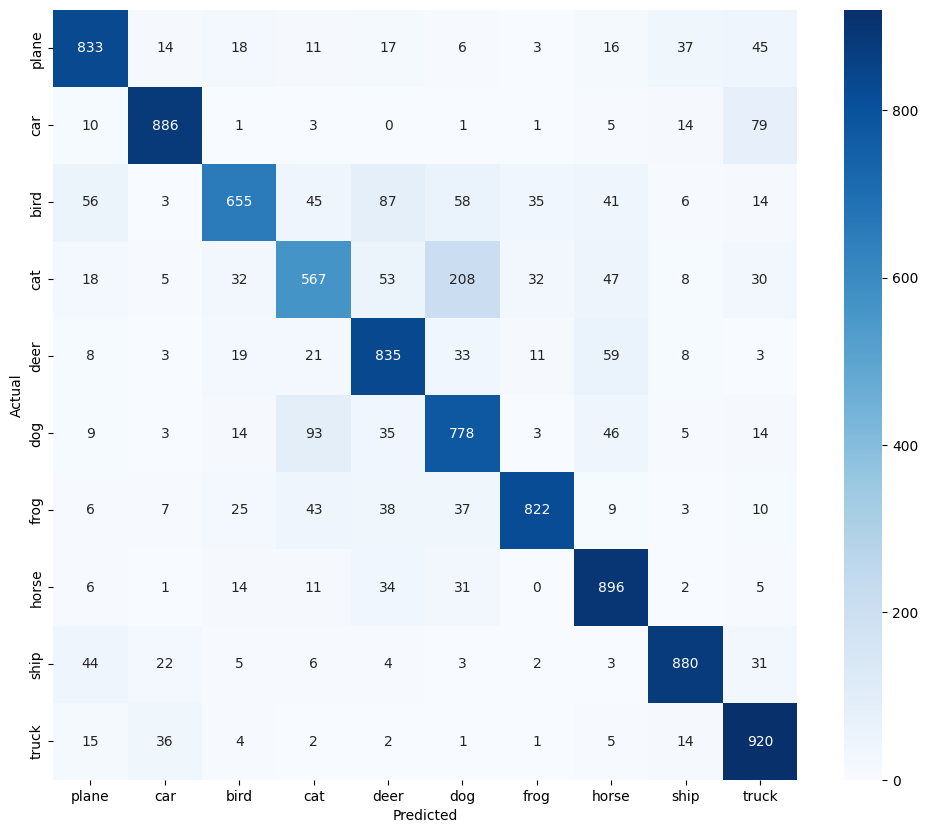

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
# 1. Get overall accuracy too:
total_correct = sum(correct_pred.values())
total_images = sum(total_pred.values())
overall_accuracy = 100 * total_correct / total_images
print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

# 3. Precision/Recall/F1 scores:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=classes, labels=list(range(10))))


Overall Accuracy: 80.72%
              precision    recall  f1-score   support

       plane       0.83      0.83      0.83      1000
         car       0.90      0.89      0.89      1000
        bird       0.83      0.66      0.73      1000
         cat       0.71      0.57      0.63      1000
        deer       0.76      0.83      0.79      1000
         dog       0.67      0.78      0.72      1000
        frog       0.90      0.82      0.86      1000
       horse       0.80      0.90      0.84      1000
        ship       0.90      0.88      0.89      1000
       truck       0.80      0.92      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

